## Training VGG16 Model - Full Face

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# path for the full face dataset
output_folder_full = r'C:\Users\joolia\Documents\project_code\output_folder'

# create an ImageDataGenerator and split the dataset for full faces
datagen_full = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train and validation data generators for full faces
train_generator_full = datagen_full.flow_from_directory(
    output_folder_full,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator_full = datagen_full.flow_from_directory(
    output_folder_full,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# load the VGG16 base model, VGGFace
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

# modifies the last layers of the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator_full.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# freeze base layers during full face training
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('vgg16_finetuned_full_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# train the model on full faces
history_full = model.fit(train_generator_full,
                         validation_data=val_generator_full,
                         epochs=30,  # Adjust based on preference
                         callbacks=[checkpoint, early_stopping])

# saves the class indices to a file after training
import pickle

with open('class_indices.pkl', 'wb') as f:
    pickle.dump(train_generator_full.class_indices, f)




Found 12468 images belonging to 915 classes.
Found 2730 images belonging to 915 classes.
Epoch 1/30
390/390 [==============================] - 247s 630ms/step - loss: 6.4676 - accuracy: 0.0517 - val_loss: 5.9857 - val_accuracy: 0.0773

Epoch 00001: val_loss improved from inf to 5.98570, saving model to vgg16_finetuned_full_model.h5
Epoch 2/30
390/390 [==============================] - 250s 642ms/step - loss: 6.1495 - accuracy: 0.0689 - val_loss: 5.9121 - val_accuracy: 0.0777

Epoch 00002: val_loss improved from 5.98570 to 5.91215, saving model to vgg16_finetuned_full_model.h5
Epoch 3/30
390/390 [==============================] - 297s 763ms/step - loss: 6.0655 - accuracy: 0.0715 - val_loss: 5.8398 - val_accuracy: 0.0897

Epoch 00003: val_loss improved from 5.91215 to 5.83978, saving model to vgg16_finetuned_full_model.h5
Epoch 4/30
390/390 [==============================] - 324s 830ms/step - loss: 5.9845 - accuracy: 0.0794 - val_loss: 5.7580 - val_accuracy: 0.0960

Epoch 00004: val_loss

KeyboardInterrupt: 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# path for the partial face dataset
output_folder_partial = r'C:\Users\joolia\Documents\project_code\partial_faces'

# create an ImageDataGenerator for partial faces
datagen_partial = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train and validation data generators for partial faces
train_generator_partial = datagen_partial.flow_from_directory(
    output_folder_partial,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator_partial = datagen_partial.flow_from_directory(
    output_folder_partial,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# check how many classes are in the partial dataset
print("Partial face dataset classes: ", train_generator_partial.num_classes)


# load the previously trained model 
model = load_model('vgg16_finetuned_full_model.h5')

# modify the final layer to match the number of classes in the partial dataset
x = model.layers[-2].output 
predictions_partial = Dense(train_generator_partial.num_classes, activation='softmax')(x)

# create a new model with the updated number of classes
model_partial = Model(inputs=model.input, outputs=predictions_partial)

# unfreezed layers for fine-tuning 
for layer in model_partial.layers[-4:]:
    layer.trainable = True

# recompiling the model
model_partial.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# define callbacks for saving the model and early stopping
checkpoint = ModelCheckpoint('vgg16_finetuned_partial_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# trains the model on partial faces
history_partial = model_partial.fit(train_generator_partial,
                                    validation_data=val_generator_partial,
                                    epochs=100, 
                                    callbacks=[checkpoint, early_stopping])


KeyboardInterrupt: 

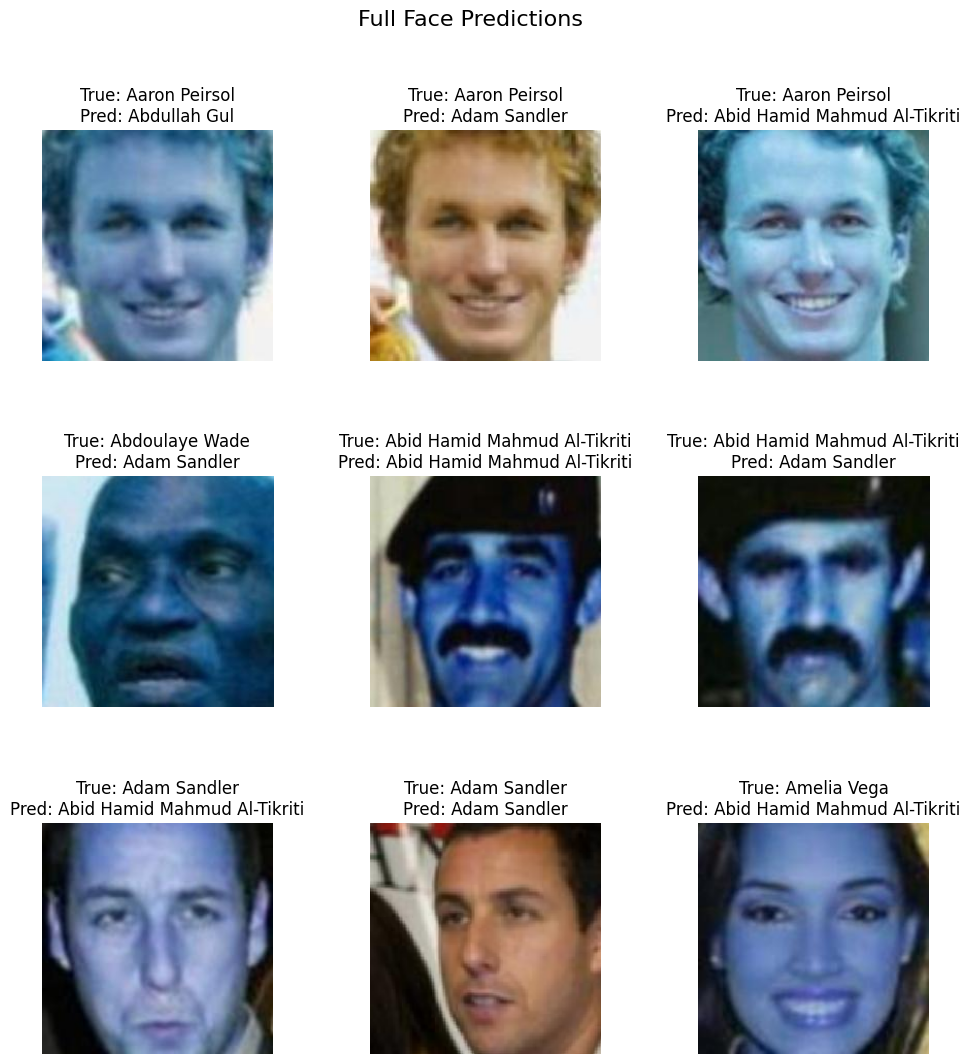

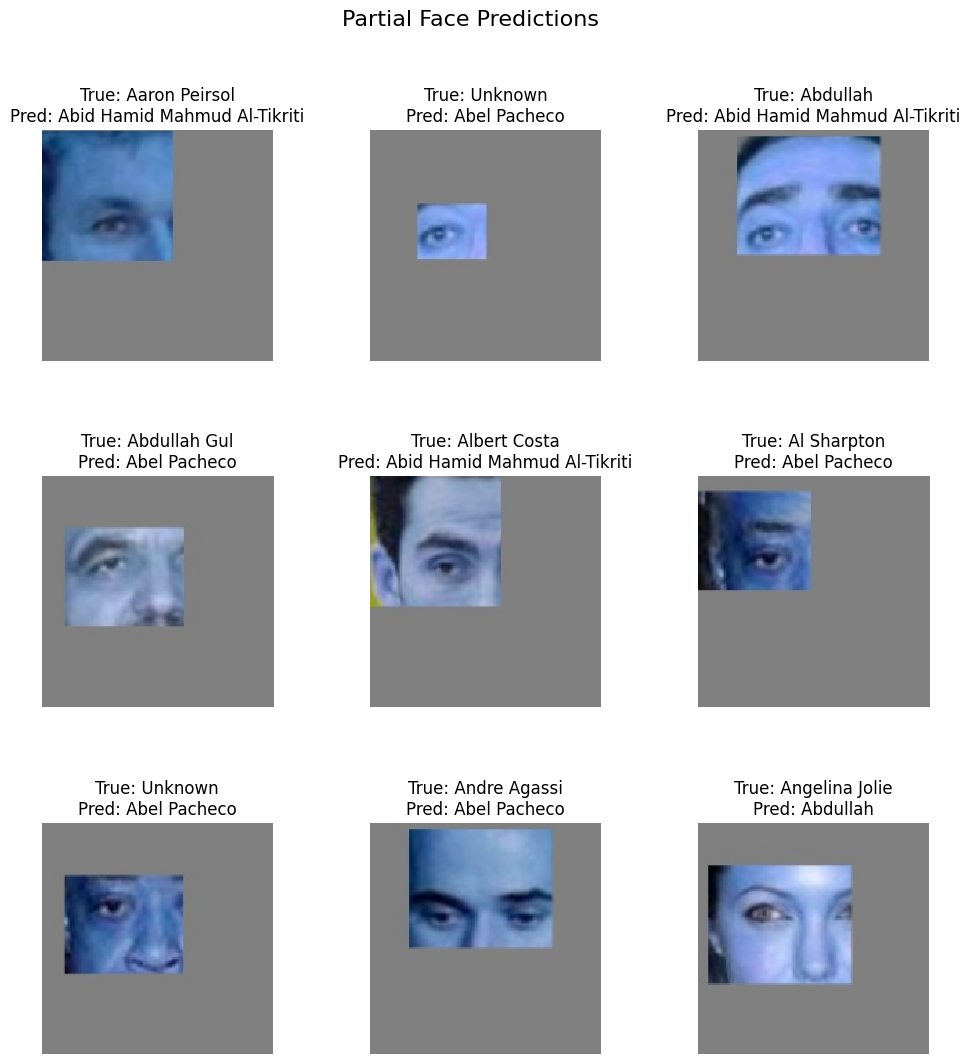

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# loading the trained model
model = load_model('vgg16_finetuned_partial_model.h5')


true_labels = {
    'Aaron_Peirsol_0001.jpg': 'Aaron Peirsol',
    'Aaron_Peirsol_0001.png': 'Aaron Peirsol',
    'Aaron_Peirsol_0003.jpg': 'Aaron Peirsol',
    'Adam_Sandler_0001.jpg': 'Adam Sandler',
    'Adam_Sandler_0002.png': 'Adam Sandler',
    'Abdoulaye_Wade_0001.jpg':'Abdoulaye Wade',
    'Amelia_Vega_0002.jpg': 'Amelia Vega',
    'Abid_Hamid_Mahmud_Al-Tikriti_0001.jpg':'Abid Hamid Mahmud Al-Tikriti', 
    'Abid_Hamid_Mahmud_Al-Tikriti_0003.jpg':'Abid Hamid Mahmud Al-Tikriti', 
    'Aaron_Peirsol_0002.jpg': 'Aaron Peirsol',
    'Abdullah_0002.jpg': 'Abdullah',
    'Abdullah_Gul_0008.jpg': 'Abdullah Gul',
    'Al_Sharpton_0006 copy.jpg': 'Al Sharpton',
    'Albert_Costa_0006.jpg': 'Albert Costa',
    'Andre_Agassi_0030.jpg': 'Andre Agassi',
    'Angelina_Jolie_0006.jpg': 'Angelina Jolie', 
    'Rick_Santorum_0002.jpg': 'Rick Santorum'
}
# folder paths
folders = {
    'full': r'C:\Users\joolia\Documents\project_code\live_demo_images\full',
    'partial': r'C:\Users\joolia\Documents\project_code\live_demo_images\partial'
}

# full class_labels 
class_labels = {
    0: 'Aaron Peirsol', 1: 'Abdoulaye Wade', 2: 'Abdullah', 3: 'Abdullah Gul', 
    4: 'Abdullah al-Attiyah', 5: 'Abel Pacheco', 6: 'Abid Hamid Mahmud Al-Tikriti', 
    7: 'Adam Sandler', 8: 'Adel Al-Jubeir', 9: 'Adolfo Aguilar Zinser', 
    10: 'Adrien Brody', 11: 'Ahmed Chalabi', 12: 'Ai Sugiyama', 
    13: 'Aicha El Ouafi', 14: 'Akbar Hashemi Rafsanjani', 15: 'Akhmed Zakayev', 
    16: 'Al Gore', 17: 'Al Pacino', 18: 'Al Sharpton', 19: 'Alan Greenspan', 
    20: 'Alastair Campbell', 21: 'Albert Costa', 22: 'Alec Baldwin', 
    23: 'Alejandro Avila', 24: 'Alejandro Toledo', 25: 'Aleksander Kwasniewski',
    26: 'Alex Sink', 27: 'Alexander Downer', 28: 'Alexander Losyukov',
    29: 'Alexandra Stevenson', 30: 'Ali Khamenei', 31: 'Ali Naimi',
    32: 'Alison Lohman', 33: 'Allyson Felix', 34: 'Alvaro Noboa',
    35: 'Alvaro Silva Calderon', 36: 'Alvaro Uribe', 37: 'Amanda Bynes',
    38: 'Amelia Vega', 39: 'Amelie Mauresmo', 40: 'Amer al-Saadi',
    41: 'Ana Guevara', 42: 'Ana Palacio', 43: 'Anastasia Myskina',
    44: 'Anders Ebbeson', 45: 'Anders Fogh Rasmussen', 46: 'Andre Agassi',
    47: 'Andrew Weissmann', 48: 'Andy Roddick', 49: 'Angela Bassett',
    50: 'Angela Lansbury', 51: 'Angela Merkel', 52: 'Angelina Jolie',
    53: 'Angelo Reyes', 54: 'Anibal Ibarra', 55: 'Ann Veneman',
    56: 'Anna Kournikova', 57: 'Anne Krueger', 58: 'Anne McLellan',
    59: 'Annette Lu', 60: 'Antonio Banderas', 61: 'Antonio Palocci',
    62: 'Antonio Trillanes', 63: 'Antony Leung', 64: 'Ari Fleischer',
    65: 'Arianna Huffington', 66: 'Ariel Sharon', 67: 'Arlen Specter',
    68: 'Arminio Fraga', 69: 'Arnold Palmer', 70: 'Arnold Schwarzenegger',
    71: 'Arnoldo Aleman', 72: 'Art Howe', 73: 'Arturo Gatti', 74: 'Ashanti',
    75: 'Ashton Kutcher', 76: 'Atal Bihari Vajpayee', 77: 'Augustin Calleri',
    78: 'Azra Akin', 79: 'Barbara Walters', 80: 'Barbra Streisand',
    81: 'Bashar Assad', 82: 'Ben Affleck', 83: 'Ben Curtis', 84: 'Ben Howland',
    85: 'Benazir Bhutto', 86: 'Benjamin Netanyahu', 87: 'Bernard Landry',
    88: 'Bernard Law', 89: 'Bertie Ahern', 90: 'Bijan Darvish', 
    91: 'Biljana Plavsic', 92: 'Bill Callahan', 93: 'Bill Clinton', 
    94: 'Bill Frist', 95: 'Bill Gates', 96: 'Bill Graham', 
    97: 'Bill McBride', 98: 'Bill Paxton', 99: 'Bill Simon',
    100: 'Billy Crystal', 101: 'Binyamin Ben-Eliezer', 102: 'Bob Dole',
    103: 'Bob Graham', 104: 'Bob Hope', 105: 'Bob Huggins',
    106: 'Bob Stoops', 107: 'Bono', 108: 'Boris Becker', 
    109: 'Brad Garrett', 110: 'Brad Johnson', 111: 'Branko Crvenkovski',
    112: 'Bridget Fonda', 113: 'Bridgette Wilson-Sampras', 114: 'Britney Spears',
    115: 'Bruce Springsteen', 116: 'Bud Selig', 117: 'Bulent Ecevit',
    118: 'Calista Flockhart', 119: 'Cameron Diaz', 120: 'Candice Bergen',
    121: 'Candie Kung', 122: 'Carla Del Ponte', 123: 'Carlo Ancelotti',
    124: 'Carlos Manuel Pruneda', 125: 'Carlos Menem', 126: 'Carlos Moya',
    127: 'Carlos Ortega', 128: 'Carlos Ruiz', 129: 'Carlos Vives',
    130: 'Carly Fiorina', 131: 'Carmen Electra', 132: 'Carolina Kluft',
    133: 'Caroline Kennedy', 134: 'Carolyn Dawn Johnson', 135: 'Carrie-Anne Moss',
    136: 'Carson Palmer', 137: 'Cate Blanchett', 138: 'Catherine Deneuve',
    139: 'Catherine Zeta-Jones', 140: 'Cathy Freeman', 141: 'Cecilia Bolocco',
    142: 'Celine Dion', 143: 'Cesar Gaviria', 144: 'Chan Gailey',
    145: 'Chanda Rubin', 146: 'Charles Bronson', 147: 'Charles Moose',
    148: 'Charles Taylor', 149: 'Charlton Heston', 150: 'Chen Shui-bian',
    151: 'Cherie Blair', 152: 'Chick Hearn', 153: 'Choi Sung-hong',
    154: 'Christian Longo', 155: 'Christina Aguilera', 156: 'Christine Baumgartner',
    157: 'Christine Ebersole', 158: 'Christine Gregoire', 159: 'Christine Todd Whitman',
    160: 'Christopher Reeve', 161: 'Christopher Walken', 162: 'Cindy Crawford',
    163: 'Ciro Gomes', 164: 'Claire Danes', 165: 'Clara Harris',
    166: 'Clare Short', 167: 'Claudia Pechstein', 168: 'Claudia Schiffer',
    169: 'Clay Aiken', 170: 'Clint Eastwood', 171: 'Colin Farrell',
    172: 'Colin Montgomerie', 173: 'Colin Powell', 174: 'Conan OBrien',
    175: 'Conchita Martinez', 176: 'Condoleezza Rice', 177: 'Constance Marie',
    178: 'Coretta Scott King', 179: 'Costas Simitis', 180: 'Cruz Bustamante',
    181: 'Daisy Fuentes', 182: 'Dale Earnhardt Jr', 183: 'Dan Morales',
    184: 'Daniel Day-Lewis', 185: 'Daniel Radcliffe', 186: 'Dave Campo',
    187: 'David Anderson', 188: 'David Beckham', 189: 'David Caruso',
    190: 'David Heymann', 191: 'David Hyde Pierce', 192: 'David Nalbandian',
    193: 'David Stern', 194: 'David Trimble', 195: 'David Wells',
    196: 'Dean Barkley', 197: 'Debbie Reynolds', 198: 'Debra Messing',
    199: 'Demi Moore', 200: 'Dennis Hastert', 201: 'Dennis Kucinich',
    202: 'Denzel Washington', 203: 'Derek Jeter', 204: 'Diana Krall',
    205: 'Diana Munz', 206: 'Dianne Feinstein', 207: 'Dick Cheney',
    208: 'Dick Clark', 209: 'Dominique de Villepin', 210: 'Don Siegelman',
    211: 'Donald Fehr', 212: 'Donald Pettit', 213: 'Donald Rumsfeld',
    214: 'Donatella Versace', 215: 'Doris Roberts', 216: 'Doris Schroeder',
    217: 'Doug Melvin', 218: 'Duane Lee Chapman', 219: 'Ed Rosenthal',
    220: 'Ed Smart', 221: 'Edmund Hillary', 222: 'Edmund Stoiber',
    223: 'Eduard Shevardnadze', 224: 'Eduardo Duhalde', 225: 'Edward Kennedy',
    226: 'Edward Lu', 227: 'Edwin Edwards', 228: 'Edwina Currie',
    229: 'Eileen Coparropa', 230: 'Elena Bovina', 231: 'Eliane Karp',
    232: 'Elijah Wood', 233: 'Elizabeth Dole', 234: 'Elizabeth Hurley',
    235: 'Elizabeth Smart', 236: 'Elsa Zylberstein', 237: 'Elton John',
    238: 'Emanuel Ginobili', 239: 'Emma Thompson', 240: 'Emma Watson',
    241: 'Emmanuelle Beart', 242: 'Enrique Bolanos', 243: 'Eric Robert Rudolph',
    244: 'Erik Morales', 245: 'Erika Harold', 246: 'Erin Runnion',
    247: 'Ernie Els', 248: 'Ethan Hawke', 249: 'Evan Rachel Wood',
    250: 'Fabrice Santoro', 251: 'Farouk al-Sharaa', 252: 'Faye Dunaway',
    253: 'Fayssal Mekdad', 254: 'Federico Trillo', 255: 'Felipe Perez Roque',
    256: 'Fernando Gonzalez', 257: 'Fernando Henrique Cardoso', 258: 'Fernando Vargas',
    259: 'Fidel Castro', 260: 'Filippo Inzaghi', 261: 'Francisco Flores',
    262: 'Frank Cassell', 263: 'Frank Solich', 264: 'Franz Fischler',
    265: 'Franz Muentefering', 266: 'Fred Eckhard', 267: 'Fred Thompson',
    268: 'Fujio Cho', 269: 'GL Peiris', 270: 'Gary Carter',
    271: 'Gary Doer', 272: 'Gene Robinson', 273: 'Geoff Hoon',
    274: 'George Clooney', 275: 'George Galloway', 276: 'George HW Bush',
    277: 'George Lopez', 278: 'George Papandreou', 279: 'George Pataki',
    280: 'George Robertson', 281: 'George Ryan', 282: 'George Voinovich',
    283: 'George W Bush', 284: 'Geraldine Chaplin', 285: 'Gerhard Schroeder',
    286: 'German Khan', 287: 'Gerry Adams', 288: 'Gian Marco',
    289: 'Gianna Angelopoulos-Daskalaki', 290: 'Gil de Ferran', 291: 'Gilberto Rodriguez Orejuela',
    292: 'Giuseppe Gibilisco', 293: 'Glafcos Clerides', 294: 'Gloria Macapagal Arroyo',
    295: 'Gloria Trevi', 296: 'Goldie Hawn', 297: 'Gonzalo Sanchez de Lozada',
    298: 'Gordon Brown', 299: 'Grant Hackett', 300: 'Gray Davis',
    301: 'Greg Rusedski', 302: 'Gregg Popovich', 303: 'Gro Harlem Brundtland',
    304: 'Guillermo Canas', 305: 'Guillermo Coria', 306: 'Gunter Pleuger',
    307: 'Gus Van Sant', 308: 'Gustavo Kuerten', 309: 'Gwendal Peizerat',
    310: 'Gwyneth Paltrow', 311: 'Habib Rizieq', 312: 'Hal Gehman',
    313: 'Halle Berry', 314: 'Hamid Karzai', 315: 'Hans Blix',
    316: 'Hans Eichel', 317: 'Harrison Ford', 318: 'Harry Schmidt',
    319: 'Heath Ledger', 320: 'Heather Mills', 321: 'Hector Babenco',
    322: 'Hee-Won Han', 323: 'Heidi Fleiss', 324: 'Heidi Klum',
    325: 'Heinz Feldmann', 326: 'Heizo Takenaka', 327: 'Helen Clark',
    328: 'Herb Sendek', 329: 'Hilary Duff', 330: 'Hillary Clinton',
    331: 'Hipolito Mejia', 332: 'Hitomi Soga', 333: 'Holly Hunter',
    334: 'Horst Koehler', 335: 'Hosni Mubarak', 336: 'Howard Dean',
    337: 'Hu Jintao', 338: 'Hugh Grant', 339: 'Hugo Chavez',
    340: 'Hun Sen', 341: 'Iain Duncan Smith', 342: 'Ian McKellen',
    343: 'Ian Thorpe', 344: 'Igor Ivanov', 345: 'Ilan Ramon',
    346: 'Intisar Ajouri', 347: 'Isabella Rossellini', 348: 'JK Rowling',
    349: 'Jack Nicholson', 350: 'Jack Straw', 351: 'Jackie Chan',
    352: 'Jacques Chirac', 353: 'Jacques Rogge', 354: 'Jake Gyllenhaal',
    355: 'James Blake', 356: 'James Caan', 357: 'James Cameron',
    358: 'James Cunningham', 359: 'James Gandolfini', 360: 'James Kelly',
    361: 'James Kopp', 362: 'James McGreevey', 363: 'James Traficant',
    364: 'James Wolfensohn', 365: 'Jan-Michael Gambill', 366: 'Jan Ullrich',
    367: 'Janet Napolitano', 368: 'Jason Kidd', 369: 'Javier Solana',
    370: 'Javier Weber', 371: 'Jay Garner', 372: 'Jay Leno',
    373: 'Jayson Williams', 374: 'Jean-David Levitte', 375: 'Jean-Francois Pontal',
    376: 'Jean-Pierre Raffarin', 377: 'Jean Charest', 378: 'Jean Chretien',
    379: 'Jeb Bush', 380: 'Jeff Van Gundy', 381: 'Jelena Dokic',
    382: 'Jennifer Aniston', 383: 'Jennifer Capriati', 384: 'Jennifer Connelly',
    385: 'Jennifer Garner', 386: 'Jennifer Keller', 387: 'Jennifer Lopez',
    388: 'Jeong Se-hyun', 389: 'Jeremy Greenstock', 390: 'Jerry Regier',
    391: 'Jerry Springer', 392: 'Jesse Harris', 393: 'Jesse Jackson',
    394: 'Jesse Ventura', 395: 'Jiang Zemin', 396: 'Jim Carrey',
    397: 'Jim Edmonds', 398: 'Jim Furyk', 399: 'Jim Hahn',
    400: 'Jim OBrien', 401: 'Jim Tressel', 402: 'Jimmy Carter',
    403: 'Jiri Novak', 404: 'Joan Laporta', 405: 'Jodie Foster',
    406: 'Joe Lieberman', 407: 'Joe Nichols', 408: 'Joe Torre',
    409: 'John Abizaid', 410: 'John Allen Muhammad', 411: 'John Ashcroft',
    412: 'John Bolton', 413: 'John Edwards', 414: 'John Howard',
    415: 'John Kerry', 416: 'John Malkovich', 417: 'John Manley',
    418: 'John Mayer', 419: 'John McCain', 420: 'John Negroponte',
    421: 'John Paul II', 422: 'John Reid', 423: 'John Rosa',
    424: 'John Snow', 425: 'John Stockton', 426: 'John Swofford',
    427: 'John Travolta', 428: 'John Warner', 429: 'Johnny Tapia',
    430: 'Jon Corzine', 431: 'Jon Gruden', 432: 'Jon Voight',
    433: 'Jonathan Edwards', 434: 'Jong Wook Lee', 435: 'Jorge Batlle',
    436: 'Joschka Fischer', 437: 'Jose Canseco', 438: 'Jose Manuel Durao Barroso',
    439: 'Jose Maria Aznar', 440: 'Jose Sarney', 441: 'Jose Serra',
    442: 'Jose Theodore', 443: 'Joseph Biden', 444: 'Joseph Deiss',
    445: 'Joseph Estrada', 446: 'Juan Carlos Ferrero', 447: 'Juan Ignacio Chela',
    448: 'Juan Manuel Marquez', 449: 'Juan Pablo Montoya', 450: 'Juanes',
    451: 'Julia Tymoshenko', 452: 'Julianne Moore', 453: 'Julie Gerberding',
    454: 'Junichiro Koizumi', 455: 'Justin Guarini', 456: 'Justin Leonard',
    457: 'Justin Timberlake', 458: 'Justine Henin', 459: 'Justine Pasek',
    460: 'Kalpana Chawla', 461: 'Kamal Kharrazi', 462: 'Kate Hudson',
    463: 'Kate Winslet', 464: 'Katherine Harris', 465: 'Kathleen Kennedy Townsend',
    466: 'Katie Harman', 467: 'Keanu Reeves', 468: 'Keith Bogans',
    469: 'Kelly Clarkson', 470: 'Kelvin Sampson', 471: 'Kemal Dervis',
    472: 'Ken Macha', 473: 'Kenneth Bowersox', 474: 'Kevin Costner',
    475: 'Kevin Spacey', 476: 'Kim Clijsters', 477: 'Kim Dae-jung',
    478: 'Kim Jong-Il', 479: 'Kim Ryong-sung', 480: 'Kim Yong-il',
    481: 'Kimi Raikkonen', 482: 'King Abdullah II', 483: 'Kirk Johnson',
    484: 'Kjell Magne Bondevik', 485: 'Kobe Bryant', 486: 'Kofi Annan',
    487: 'Kristanna Loken', 488: 'Kristen Breitweiser', 489: 'Kristin Davis',
    490: 'Kurt Warner', 491: 'Kwon Yang-sook', 492: 'LK Advani',
    493: 'Laila Ali', 494: 'Lance Armstrong', 495: 'Lance Bass',
    496: 'Larry Brown', 497: 'Larry Coker', 498: 'Larry Ellison',
    499: 'Larry Thompson', 500: 'Lars Von Trier', 501: 'Laura Bush',
    502: 'Laura Linney', 503: 'LeBron James', 504: 'Lee Hoi-chang',
    505: 'Lee Soo-hyuck', 506: 'Lennox Lewis', 507: 'Lenny Wilkens',
    508: 'Leonardo DiCaprio', 509: 'Leonid Kuchma', 510: 'Lesley McCulloch',
    511: 'Leslie Caldwell', 512: 'Leszek Miller', 513: 'Li Peng',
    514: 'Li Zhaoxing', 515: 'Liam Neeson', 516: 'Lindsay Davenport',
    517: 'Lino Oviedo', 518: 'Lisa Marie Presley', 519: 'Liza Minnelli',
    520: 'Lleyton Hewitt', 521: 'Lou Piniella', 522: 'Luciano Pavarotti',
    523: 'Lucio Gutierrez', 524: 'Lucy Liu', 525: 'Ludivine Sagnier',
    526: 'Luis Ernesto Derbez Bautista', 527: 'Luis Figo', 528: 'Luis Gonzalez Macchi',
    529: 'Luis Horna', 530: 'Luiz Inacio Lula da Silva', 531: 'Lynn Redgrave',
    532: 'Lynne Cheney', 533: 'Madeleine Albright', 534: 'Madonna',
    535: 'Magdalena Maleeva', 536: 'Mahathir Mohamad', 537: 'Mahmoud Abbas',
    538: 'Makhdoom Amin Fahim', 539: 'Marat Safin', 540: 'Marc Grossman',
    541: 'Marcelo Ebrard', 542: 'Marcelo Rios', 543: 'Marcelo Salas',
    544: 'Marco Antonio Barrera', 545: 'Maria Shriver', 546: 'Maria Soledad Alvear Valenzuela',
    547: 'Mariah Carey', 548: 'Mariana Pollack', 549: 'Mariangel Ruiz Torrealba',
    550: 'Marieta Chrousala', 551: 'Mark Gottfried', 552: 'Mark Hurlbert',
    553: 'Mark Philippoussis', 554: 'Mark Richt', 555: 'Mark Wahlberg',
    556: 'Martha Burk', 557: 'Martha Lucia Ramirez', 558: 'Martha Stewart',
    559: 'Martin McGuinness', 560: 'Martin Scorsese', 561: 'Martin Verkerk',
    562: 'Martina Hingis', 563: 'Martina McBride', 564: 'Marty Mornhinweg',
    565: 'Mary-Kate Olsen', 566: 'Mary Carey', 567: 'Mary Landrieu',
    568: 'Mary Steenburgen', 569: 'Masum Turker', 570: 'Mathias Reichhold',
    571: 'Matt Damon', 572: 'Matt Dillon', 573: 'Matt Doherty',
    574: 'Matthew Broderick', 575: 'Matthew Perry', 576: 'Megan Mullally',
    577: 'Megawati Sukarnoputri', 578: 'Melanie Griffith', 579: 'Meryl Streep',
    580: 'Mian Khursheed Mehmood Kasuri', 581: 'Michael Ballack', 582: 'Michael Bloomberg',
    583: 'Michael Caine', 584: 'Michael Chang', 585: 'Michael Chiklis',
    586: 'Michael Douglas', 587: 'Michael Jackson', 588: 'Michael Jordan',
    589: 'Michael Moore', 590: 'Michael Phelps', 591: 'Michael Powell',
    592: 'Michael Schumacher', 593: 'Michael Winterbottom', 594: 'Michelle Kwan',
    595: 'Michelle Pfeiffer', 596: 'Michelle Yeoh', 597: 'Mick Jagger',
    598: 'Mike Krzyzewski', 599: 'Mike Martz', 600: 'Mike Myers',
    601: 'Mike Tyson', 602: 'Mike Weir', 603: 'Mikhail Gorbachev',
    604: 'Mikhail Kasyanov', 605: 'Mikhail Wehbe', 606: 'Mikhail Youzhny',
    607: 'Milo Djukanovic', 608: 'Milo Maestrecampo', 609: 'Mireya Moscoso',
    610: 'Mitchell Daniels', 611: 'Mohamed ElBaradei', 612: 'Mohammad Khatami',
    613: 'Mohammed Al-Douri', 614: 'Mohammed Baqir al-Hakim', 615: 'Monica Bellucci',
    616: 'Monica Lewinsky', 617: 'Monica Seles', 618: 'Monique Garbrecht-Enfeldt',
    619: 'Moshe Katsav', 620: 'Muhammad Ali', 621: 'Muhammad Saeed al-Sahhaf',
    622: 'Mukesh Ambani', 623: 'Nabil Shaath', 624: 'Nadia Petrova',
    625: 'Naji Sabri', 626: 'Nan Wang', 627: 'Nancy Pelosi',
    628: 'Naomi Watts', 629: 'Naoto Kan', 630: 'Natalie Cole',
    631: 'Natalie Coughlin', 632: 'Natalie Maines', 633: 'Natasha McElhone',
    634: 'Nathalie Baye', 635: 'Nelson Mandela', 636: 'Nestor Kirchner',
    637: 'Nia Vardalos', 638: 'Nicanor Duarte Frutos', 639: 'Nick Nolte',
    640: 'Nicolas Cage', 641: 'Nicole Kidman', 642: 'Noah Wyle',
    643: 'Noelle Bush', 644: 'Norah Jones', 645: 'Norm Coleman',
    646: 'Norodom Sihanouk', 647: 'Omar Sharif', 648: 'Oprah Winfrey',
    649: 'Orlando Bloom', 650: 'Osama bin Laden', 651: 'Oscar De La Hoya',
    652: 'Oswaldo Paya', 653: 'Oxana Fedorova', 654: 'Ozzy Osbourne',
    655: 'Padraig Harrington', 656: 'Pamela Anderson', 657: 'Paradorn Srichaphan',
    658: 'Pascal Quignard', 659: 'Patricia Clarkson', 660: 'Patti Labelle',
    661: 'Patty Schnyder', 662: 'Paul-Henri Mathieu', 663: 'Paul Bremer',
    664: 'Paul Burrell', 665: 'Paul Gascoigne', 666: 'Paul Martin',
    667: 'Paul McCartney', 668: 'Paul McNulty', 669: 'Paul ONeill',
    670: 'Paul Sarbanes', 671: 'Paul Shanley', 672: 'Paul Tagliabue',
    673: 'Paul Wellstone', 674: 'Paul Wolfowitz', 675: 'Paula Radcliffe',
    676: 'Pedro Almodovar', 677: 'Pedro Malan', 678: 'Pedro Solbes',
    679: 'Penelope Cruz', 680: 'Pervez Musharraf', 681: 'Pete Carroll',
    682: 'Pete Sampras', 683: 'Peter Arnett', 684: 'Peter Struck',
    685: 'Petria Thomas', 686: 'Phan Van Khai', 687: 'Phil Mickelson',
    688: 'Pierce Brosnan', 689: 'Pierre Pettigrew', 690: 'Placido Domingo',
    691: 'Prince Charles', 692: 'Prince Claus', 693: 'Prince Harry',
    694: 'Prince Naruhito', 695: 'Prince Willem-Alexander', 696: 'Princess Caroline',
    697: 'Pupi Avati', 698: 'Queen Beatrix', 699: 'Queen Elizabeth II',
    700: 'Queen Latifah', 701: 'Queen Rania', 702: 'Rachel Griffiths',
    703: 'Rachel Hunter', 704: 'Rafael Ramirez', 705: 'Rainer Schuettler',
    706: 'Ralf Schumacher', 707: 'Ranil Wickremasinghe', 708: 'Raoul Ruiz',
    709: 'Ray Allen', 710: 'Ray Romano', 711: 'Rebecca Romijn-Stamos',
    712: 'Rebekah Chantay Revels', 713: 'Recep Tayyip Erdogan', 714: 'Reese Witherspoon',
    715: 'Renee Zellweger', 716: 'Ricardo Lagos', 717: 'Ricardo Sanchez',
    718: 'Richard Armitage', 719: 'Richard Gephardt', 720: 'Richard Gere',
    721: 'Richard Krajicek', 722: 'Richard Myers', 723: 'Richard Virenque',
    724: 'Rick Barnes', 725: 'Rick Carlisle', 726: 'Rick Dinse',
    727: 'Rick Perry', 728: 'Rick Pitino', 729: 'Rick Romley',
    730: 'Rick Santorum', 731: 'Rick Stansbury', 732: 'Rita Grande',
    733: 'Rita Wilson', 734: 'Rob Lowe', 735: 'Rob Marshall',
    736: 'Robbie Williams', 737: 'Robert Blake', 738: 'Robert Bonner',
    739: 'Robert De Niro', 740: 'Robert Duvall', 741: 'Robert Evans',
    742: 'Robert Kocharian', 743: 'Robert Mueller', 744: 'Robert Redford',
    745: 'Robert Torricelli', 746: 'Robert Zoellick', 747: 'Roberto Carlos',
    748: 'Roberto Marinho', 749: 'Rod Stewart', 750: 'Roger Federer',
    751: 'Roger Moore', 752: 'Roh Moo-hyun', 753: 'Roman Polanski',
    754: 'Romano Prodi', 755: 'Ron Dittemore', 756: 'Ronald Reagan',
    757: 'Ronaldo Luis Nazario de Lima', 758: 'Roseanne Barr', 759: 'Roy Moore',
    760: 'Roy Williams', 761: 'Rubens Barrichello', 762: 'Rudolph Giuliani',
    763: 'Rupert Grint', 764: 'Russell Simmons', 765: 'Sachiko Yamada',
    766: 'Saddam Hussein', 767: 'Sadie Frost', 768: 'Sally Field',
    769: 'Sally Kirkland', 770: 'Salma Hayek', 771: 'Salman Rushdie',
    772: 'Sam Bith', 773: 'Sam Torrance', 774: 'Samuel Waksal',
    775: 'Sandra Bullock', 776: 'Sarah Hughes', 777: 'Sarah Jessica Parker',
    778: 'Sarah Michelle Gellar', 779: 'Scott McClellan', 780: 'Scott Peterson',
    781: 'Sean Astin', 782: 'Sean OKeefe', 783: 'Sean Patrick OMalley',
    784: 'Sean Penn', 785: 'Sebastian Saja', 786: 'Sebastien Grosjean',
    787: 'Sepp Blatter', 788: 'Serena Williams', 789: 'Sergei Ivanov',
    790: 'Sergey Lavrov', 791: 'Sergio Vieira De Mello', 792: 'Sharon Osbourne',
    793: 'Sharon Stone', 794: 'Shaul Mofaz', 795: 'Sheila Copps',
    796: 'Sheryl Crow', 797: 'Shimon Peres', 798: 'Sila Calderon',
    799: 'Silvan Shalom', 800: 'Silvia Farina Elia', 801: 'Silvio Berlusconi',
    802: 'Slobodan Milosevic', 803: 'Sonia Gandhi', 804: 'Sophia Loren',
    805: 'Sourav Ganguly', 806: 'Spencer Abraham', 807: 'Stanley McChrystal',
    808: 'Steffi Graf', 809: 'Steve Ballmer', 810: 'Steve Lavin',
    811: 'Steve Mariucci', 812: 'Steve Nash', 813: 'Steven Spielberg',
    814: 'Stockard Channing', 815: 'Strom Thurmond', 816: 'Susan Sarandon',
    817: 'Susilo Bambang Yudhoyono', 818: 'Sylvester Stallone', 819: 'Taha Yassin Ramadan',
    820: 'Tang Jiaxuan', 821: 'Tariq Aziz', 822: 'Tassos Papadopoulos',
    823: 'Taufik Hidayat', 824: 'Terry McAuliffe', 825: 'Thabo Mbeki',
    826: 'Thaksin Shinawatra', 827: 'Theodore Tweed Roosevelt', 828: 'Theresa May',
    829: 'Thierry Falise', 830: 'Thomas Fargo', 831: 'Thomas OBrien',
    832: 'Thomas Rupprath', 833: 'Tiger Woods', 834: 'Tim Allen',
    835: 'Tim Conway', 836: 'Tim Duncan', 837: 'Tim Henman',
    838: 'Tim Robbins', 839: 'Todd Haynes', 840: 'Tom Craddick',
    841: 'Tom Crean', 842: 'Tom Cruise', 843: 'Tom Daschle',
    844: 'Tom Hanks', 845: 'Tom Harkin', 846: 'Tom Reilly',
    847: 'Tom Ridge', 848: 'Tom Watson', 849: 'Tommy Franks',
    850: 'Tommy Haas', 851: 'Tommy Robredo', 852: 'Tommy Thompson',
    853: 'Toni Braxton', 854: 'Tony Bennett', 855: 'Tony Blair',
    856: 'Tony Curtis', 857: 'Tony Shalhoub', 858: 'Tony Stewart',
    859: 'Toshihiko Fukui', 860: 'Trent Lott', 861: 'Tubby Smith',
    862: 'Tung Chee-hwa', 863: 'Tyron Garner', 864: 'Uma Thurman',
    865: 'Vaclav Havel', 866: 'Valentino Rossi', 867: 'Valery Giscard dEstaing',
    868: 'Vanessa Incontrada', 869: 'Vanessa Redgrave', 870: 'Vanessa Williams',
    871: 'Venus Williams', 872: 'Vicente Fernandez', 873: 'Vicente Fox',
    874: 'Victoria Beckham', 875: 'Victoria Clarke', 876: 'Vince Carter',
    877: 'Vincent Brooks', 878: 'Vincent Gallo', 879: 'Vitali Klitschko',
    880: 'Vladimir Putin', 881: 'Vladimir Spidla', 882: 'Vladimiro Montesinos',
    883: 'Vojislav Kostunica', 884: 'Walter Mondale', 885: 'Wang Yingfan',
    886: 'Warren Buffett', 887: 'Wayne Ferreira', 888: 'Wayne Gretzky',
    889: 'Wen Jiabao', 890: 'William Bratton', 891: 'William Bulger',
    892: 'William Donaldson', 893: 'William Ford Jr', 894: 'William Macy',
    895: 'Win Aung', 896: 'Winona Ryder', 897: 'Wolfgang Schuessel',
    898: 'Woody Allen', 899: 'Wu Yi', 900: 'Xanana Gusmao',
    901: 'Xavier Malisse', 902: 'Yao Ming', 903: 'Yasar Yakis',
    904: 'Yashwant Sinha', 905: 'Yasser Arafat', 906: 'Yevgeny Kafelnikov',
    907: 'Yoko Ono', 908: 'Yoriko Kawaguchi', 909: 'Yu Shyi-kun',
    910: 'Zhang Ziyi', 911: 'Zhu Rongji', 912: 'Zico', 913: 'Zinedine Zidane', 
    914: 'Zoran Djindjic'
}

# predict and display true and predicted classes for images in both full and partial folders
for folder_name, folder_path in folders.items():
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # predict and display for each image in the folder
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))  
    axes = axes.ravel()

    for i, img_file in enumerate(image_files[:9]):  # limit to first 9 images
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) 

        # get prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]  # get the predicted class index
        predicted_label = class_labels.get(predicted_class, 'Unknown')  # get the predicted class name

        # find the true label for the image from your true_labels dictionary
        true_label = true_labels.get(img_file, 'Unknown')
        
        # display the image with both the true and predicted labels
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(f"{folder_name.capitalize()} Face Predictions", fontsize=16)
    plt.show()

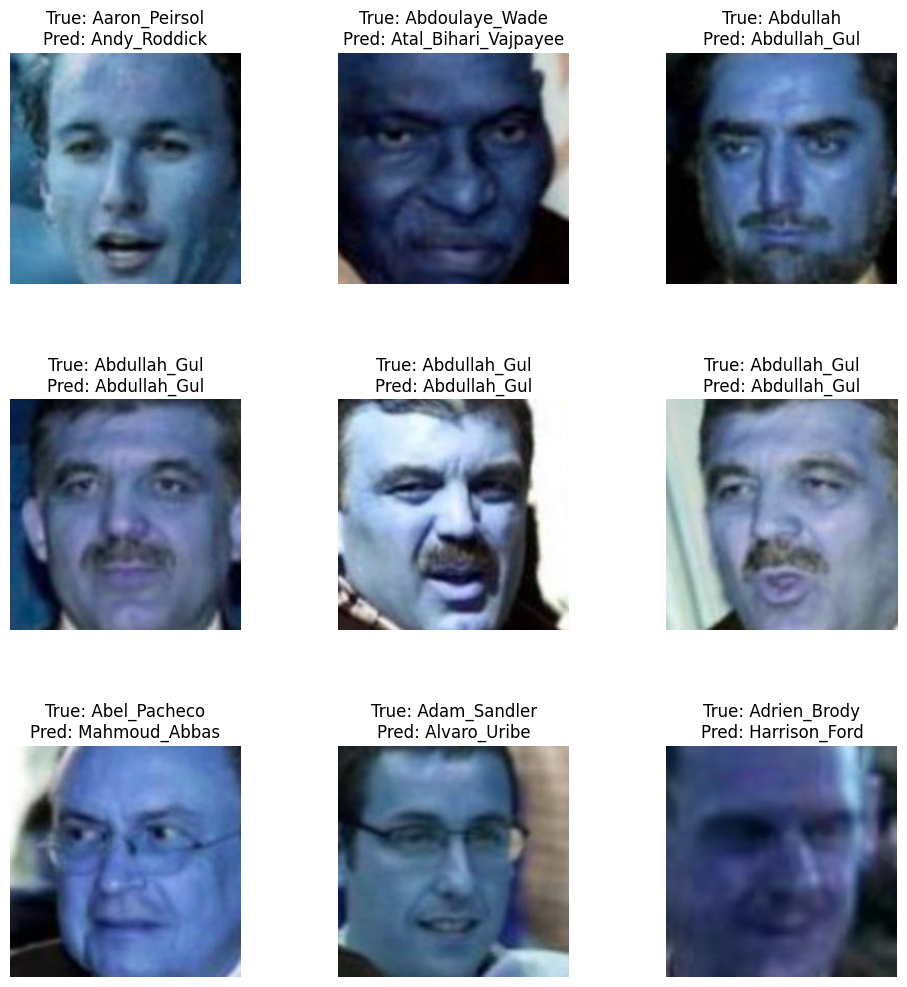

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# generate predictions for the test set
test_generator.reset()  # resets the generator for correct indexing
preds = model.predict(test_generator)

# gets the predicted class labels
predicted_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# display a few predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, 9):
    img_path, true_label_index = test_generator.filepaths[i], true_classes[i]
    img = image.load_img(img_path, target_size=(224, 224))  # Load the image
    img = np.array(img)
    true_label = class_labels[true_label_index]
    predicted_label = class_labels[predicted_classes[i]]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()
